In [8]:
import pandas as pd

train = pd.read_csv(r"C:\Users\paulw\Documents\QuantSpark\semantic_scanner\data\clause_class_train_data.csv")
test = pd.read_csv(r"C:\Users\paulw\Documents\QuantSpark\semantic_scanner\data\clause_class_test_data.csv")

sample = train[['text','label']].loc[0]

print(sample['text'])
print(sample['label'])

For purposes of the preceding sentence, and without limiting its generality, any merger, consolidation or reorganization involving Licensee (regardless of whether Licensee is a surviving or disappearing entity) will be deemed to be a transfer of rights, obligations or performance under this Agreement for which Licensor's prior written consent is required. (Page 15)
Change of Control


In [43]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from datasets import Dataset
import pandas as pd
import numpy as np
import json
from torch.utils.data import DataLoader
from tqdm import tqdm

model_path = r"C:\Users\paulw\Documents\QuantSpark\semantic_scanner\models\bert-base-uncased_finetuned_16-01-2024_15-43-20"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
id2label = json.load(open(f"{model_path}"+r"\id2label.json"))
label2id = {v:k for k,v in id2label.items()}
labels = list(label2id.keys())

data = pd.read_csv(r"C:\Users\paulw\Documents\QuantSpark\semantic_scanner\data\clause_class_test_data.csv")

def preprocess_data(examples:pd.DataFrame):
    # take a batch of texts
    text = examples["text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)

    encoding["target"] = [label2id[x] for x in examples["label"]]    
    return encoding

test_dataset = Dataset.from_pandas(test)

test_dataset = test_dataset.map(preprocess_data, batched=True)

test_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

# prepare into a dataloader for batched inference
test_dataloader = DataLoader(test_dataset, batch_size=16)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.eval()
model.to(device)

act_fn = torch.nn.Softmax(dim=1)
preds = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = act_fn(logits)
        preds.append(probs.to('cpu').detach().numpy())

100%|██████████| 264/264 [01:00<00:00,  4.35it/s]


In [50]:
test['predictions'] = [np.argmax(y) for x in preds for y in x]

In [54]:
test['predictions'] = [id2label[f'{x}'] for x in test['predictions']]

In [56]:
test['correct'] = test['label'] == test['predictions']

In [58]:
test['correct'].sum()/len(test)

0.7362559241706161

In [61]:
outcomes = test.groupby('label')['correct'].value_counts(normalize=True).reset_index(drop=False)

In [81]:
true_outcomes = dict()
for label in test['label'].unique():
    outcomes_filtered = outcomes.loc[outcomes['label']==label]
    if True in outcomes_filtered['correct'].unique():
        true_outcomes[label] = [outcomes_filtered.loc[outcomes_filtered['correct']==True]['proportion'].values[0]]
    else:
        true_outcomes[label] = [0]

In [82]:
true_outcomes = pd.DataFrame(true_outcomes).T.reset_index(drop=False).sort_values(by=0)

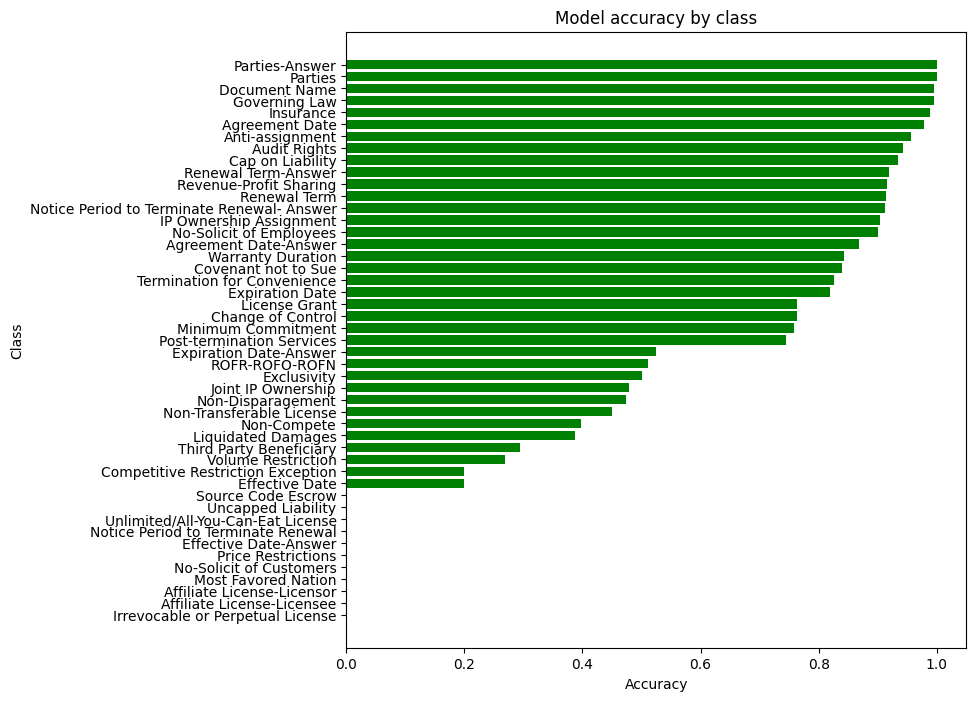

In [83]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(8,8))
ax.barh(true_outcomes['index'].values, true_outcomes[0].values, color='green')
ax.set_title('Model accuracy by class')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Class')
plt.show()

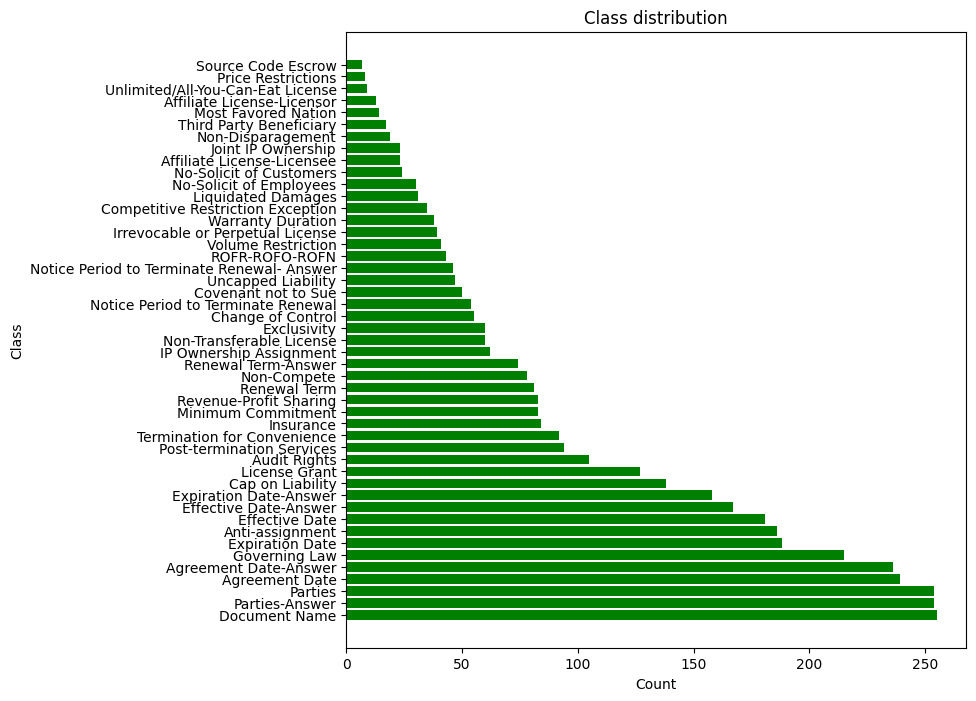

In [85]:
label_counts = test['label'].value_counts()

fig, ax = plt.subplots(figsize=(8,8))
ax.barh(label_counts.index, label_counts.values, color='green')
ax.set_title('Class distribution')
ax.set_xlabel('Count')
ax.set_ylabel('Class')
plt.show()

In [101]:
# test['actual_label_id'] = [int(label2id[x]) for x in test['label']]
# test['predicted_label_id'] = [int(label2id[x]) for x in test['predictions']]

# create a confusion matrix and output as pandas dataframe
confusion_matrix = pd.crosstab(test['label'], test['predictions'], rownames=['Actual'], colnames=['Predicted'], margins=True)

# drop all column and index
confusion_matrix = confusion_matrix.drop('All', axis=1).drop('All', axis=0)

# normalize the confusion matrix
confusion_matrix = (confusion_matrix/confusion_matrix.sum(axis=1)).fillna(0).round(2)

# sort columns and rows by order of labels
confusion_matrix = confusion_matrix[labels].loc[labels]
confusion_matrix.to_csv('./confusion_matrix.csv', index=True)

In [44]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("agnihotri/autotrain-contract_type-809725368")

tokenizer = AutoTokenizer.from_pretrained("agnihotri/autotrain-contract_type-809725368")

inputs = tokenizer("I love AutoTrain", return_tensors="pt")

outputs = model(**inputs)
probabilities = F.softmax(outputs["logits"], dim=1)
probabilities = probabilities.detach().numpy()[0]
np.argmax(probabilities)

13

In [64]:
import pandas as pd

df = pd.read_csv(r"C:\Users\paulw\Documents\QuantSpark\semantic_scanner\data\test_data.csv")
df = df.sample(200)

In [65]:
texts = df["text"].tolist()

preds = []
for text in texts:
    try:
        tokenized = tokenizer(text, return_tensors="pt")
        outputs = model(**tokenized)
        probabilities = F.softmax(outputs["logits"], dim=1)
        probabilities = probabilities.detach().numpy()[0]
        preds.append(np.argmax(probabilities))
    except:
        preds.append("error")

In [67]:
df["pred_int"] = preds

In [70]:
df.groupby("label")["pred_int"].value_counts(normalize=True).head(50)

label                              pred_int
Affiliate License-Licensee         error       1.000000
Affiliate License-Licensor         8           0.500000
                                   12          0.500000
Agreement Date                     13          0.692308
                                   11          0.307692
Agreement Date-Answer              13          0.923077
                                   21          0.076923
Anti-assignment                    24          0.166667
                                   12          0.166667
                                   20          0.166667
                                   10          0.166667
                                   1           0.166667
                                   11          0.166667
Audit Rights                       6           0.500000
                                   18          0.250000
                                   11          0.250000
Cap on Liability                   10          0.375000
    